**INTRODUCTION :**

This notebook is about clustering the customers using an unsupervised learning technique which is OPTICS, (ordering points to identify the clustering structure), in other words we detect clusters based on density, a groups of data points that are too dense with data are considered clusters. In our case of application, we will detect customers that are sufficiently similar to each others, these segments of customers should be dense enough to be considered as a single cluster. Resource for better understanding : https://www.geeksforgeeks.org/ml-optics-clustering-explanation/

First, we import all the necessary data, packages.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import silhouette_score
from sklearn.cluster import OPTICS
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv("../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [2]:
print(df.head(3))
print('----------')
print('Shape: ',df.shape)
print('----------')
print(df.dtypes)
print('---------- ')
print(df.isnull().sum())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
----------
Shape:  (200, 5)
----------
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object
---------- 
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


We encode the "Gender" boolean variable using two digits ( 1 for "Male", 0 for "Female" ), and delete the first column since it doesn't help the clustering process.

In [3]:
for k in range(0,200):
   if df["Gender"][k] == "Male":
       df["Gender"][k] = 1
   else :
       df["Gender"][k] = 0
df['Gender'] = df['Gender'].astype('int')
del df["CustomerID"]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


There are very small signs of correlations.

In [4]:
print(df.corr())

                          Gender       Age  Annual Income (k$)  \
Gender                  1.000000  0.060867            0.056410   
Age                     0.060867  1.000000           -0.012398   
Annual Income (k$)      0.056410 -0.012398            1.000000   
Spending Score (1-100) -0.058109 -0.327227            0.009903   

                        Spending Score (1-100)  
Gender                               -0.058109  
Age                                  -0.327227  
Annual Income (k$)                    0.009903  
Spending Score (1-100)                1.000000  


The Annual income values are dispersed within the range [20 k$,120 k$], 50% of the costumers have an annual income lower than 60 k.
25 % of the customer have an annual income greater than 80 k$

count    200.000000
mean      60.560000
std       26.264721
min       15.000000
25%       41.500000
50%       61.500000
75%       78.000000
max      137.000000
Name: Annual Income (k$), dtype: float64

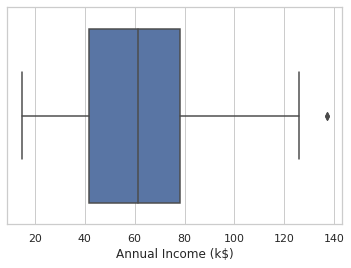

In [5]:
import seaborn as sns 
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df["Annual Income (k$)"])
df["Annual Income (k$)"].describe()

The spending score values lie within the range [1,100]. It's some sort of metric that tells you how profitable a customer is. The higher it is, the lucrative the costumer is. 

count    200.000000
mean      50.200000
std       25.823522
min        1.000000
25%       34.750000
50%       50.000000
75%       73.000000
max       99.000000
Name: Spending Score (1-100), dtype: float64


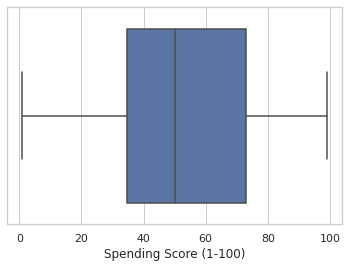

In [6]:
zx = sns.boxplot(x=df["Spending Score (1-100)"])
print(df["Spending Score (1-100)"].describe())

50% of the costumers age are below 36 years, which insinuate that the younger generation are most likely to convert to clients. Therefore we will likely target this age range

count    200.000000
mean      38.850000
std       13.969007
min       18.000000
25%       28.750000
50%       36.000000
75%       49.000000
max       70.000000
Name: Age, dtype: float64


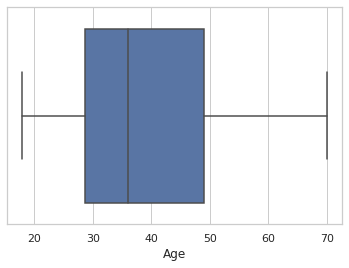

In [7]:
zx = sns.boxplot(x=df["Age"])
print(df["Age"].describe())

The distribution of Male/Female among customers

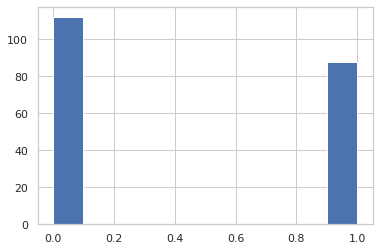

In [8]:
import matplotlib.pyplot as plt
df["Gender"].hist()
plt.show()

The OPTICS algorithms expects two paramters : 

maxeps : a distance that will be used to detect clusters, the algorithm will check each data point maxeps-neighbors, and if there's enough point in this neighborhood, a cluster will be formed
minpts : the number of points that should in the maxeps-neighborhood, in order to consider the said points as a cluster.

After multiple trials, we decided to run the OPTICS algorithm on a range of minpts values [10,50], we fixed the maxeps parameter.
For each configuration, we calculate the silhouette coefficient. We will get 40 different clustering result because we tested with different values of minpts. First we apply this approach on all the feature. We will skip some minpts values since it returns only one cluster which isn't really helpful.

The configuration that gave the highest silhouette coefficient is the one indexed with 18,
 mintpts = 23
silhoutte coefficient = 0.21


In [9]:
X = np.array(df[["Spending Score (1-100)","Annual Income (k$)","Gender","Age"]])

minpts = [i for i in range(10,51)]

maxeps = [300]*41

sil = [0]*41

for k in range(0,len(sil)):
    if k == 17 or k == 21 or k == 30 or k == 31 or k == 38 or k == 22:
        continue
    clustering = OPTICS(min_samples=minpts[k],max_eps=maxeps[k]).fit(X)
    print(clustering)
    sil[k] = silhouette_score(X,clustering.labels_)

  
maximum = max(sil)
index = sil.index(maximum)
print(index)
print("optimal minpts value :",minpts[index])
print("optimal silhouette coefficient value :",sil[index])


OPTICS(max_eps=300, min_samples=10)
OPTICS(max_eps=300, min_samples=11)
OPTICS(max_eps=300, min_samples=12)
OPTICS(max_eps=300, min_samples=13)
OPTICS(max_eps=300, min_samples=14)
OPTICS(max_eps=300, min_samples=15)
OPTICS(max_eps=300, min_samples=16)
OPTICS(max_eps=300, min_samples=17)
OPTICS(max_eps=300, min_samples=18)
OPTICS(max_eps=300, min_samples=19)
OPTICS(max_eps=300, min_samples=20)
OPTICS(max_eps=300, min_samples=21)
OPTICS(max_eps=300, min_samples=22)
OPTICS(max_eps=300, min_samples=23)
OPTICS(max_eps=300, min_samples=24)
OPTICS(max_eps=300, min_samples=25)
OPTICS(max_eps=300, min_samples=26)
OPTICS(max_eps=300, min_samples=28)
OPTICS(max_eps=300, min_samples=29)
OPTICS(max_eps=300, min_samples=30)
OPTICS(max_eps=300, min_samples=33)
OPTICS(max_eps=300, min_samples=34)
OPTICS(max_eps=300, min_samples=35)
OPTICS(max_eps=300, min_samples=36)
OPTICS(max_eps=300, min_samples=37)
OPTICS(max_eps=300, min_samples=38)
OPTICS(max_eps=300, min_samples=39)
OPTICS(max_eps=300, min_samp

Now we try the same using only : Spending score, Annual Income, Gender.
The configuration that gave the highest silhouette coefficient is the one indexed with 13,
mintpts = 23
silhoutte coefficient = 0.26365132840366795
The silhouette coefficient improved a little bit



In [10]:
X = np.array(df[["Spending Score (1-100)","Annual Income (k$)","Gender"]])

for k in range(0,len(sil)):

    clustering = OPTICS(min_samples=minpts[k],max_eps=maxeps[k]).fit(X)
    print(clustering)
    sil[k] = silhouette_score(X,clustering.labels_)

  
maximum = max(sil)
index = sil.index(maximum)
print(index)
print("optimal minpts value :",minpts[index])
print("optimal silhouette coefficient value :",sil[index])


OPTICS(max_eps=300, min_samples=10)
OPTICS(max_eps=300, min_samples=11)
OPTICS(max_eps=300, min_samples=12)
OPTICS(max_eps=300, min_samples=13)
OPTICS(max_eps=300, min_samples=14)
OPTICS(max_eps=300, min_samples=15)
OPTICS(max_eps=300, min_samples=16)
OPTICS(max_eps=300, min_samples=17)
OPTICS(max_eps=300, min_samples=18)
OPTICS(max_eps=300, min_samples=19)
OPTICS(max_eps=300, min_samples=20)
OPTICS(max_eps=300, min_samples=21)
OPTICS(max_eps=300, min_samples=22)
OPTICS(max_eps=300, min_samples=23)
OPTICS(max_eps=300, min_samples=24)
OPTICS(max_eps=300, min_samples=25)
OPTICS(max_eps=300, min_samples=26)
OPTICS(max_eps=300, min_samples=27)
OPTICS(max_eps=300, min_samples=28)
OPTICS(max_eps=300, min_samples=29)
OPTICS(max_eps=300, min_samples=30)
OPTICS(max_eps=300, min_samples=31)
OPTICS(max_eps=300, min_samples=32)
OPTICS(max_eps=300, min_samples=33)
OPTICS(max_eps=300, min_samples=34)
OPTICS(max_eps=300, min_samples=35)
OPTICS(max_eps=300, min_samples=36)
OPTICS(max_eps=300, min_samp

We tried again with : spending score, annual income, age. This one hasn't shown any improvement.

In [11]:
X = np.array(df[["Spending Score (1-100)","Annual Income (k$)","Age"]])
for k in range(0,len(sil)):
    if k == 17 or k == 21 or k == 30 or k == 31 or k == 38:
        continue
    clustering = OPTICS(min_samples=minpts[k],max_eps=maxeps[k]).fit(X)
    print(clustering)
    sil[k] = silhouette_score(X,clustering.labels_)

  
maximum = max(sil)
index = sil.index(maximum)
print(index)
print("optimal minpts value :",minpts[index])
print("optimal silhouette coefficient value",sil[index])

OPTICS(max_eps=300, min_samples=10)
OPTICS(max_eps=300, min_samples=11)
OPTICS(max_eps=300, min_samples=12)
OPTICS(max_eps=300, min_samples=13)
OPTICS(max_eps=300, min_samples=14)
OPTICS(max_eps=300, min_samples=15)
OPTICS(max_eps=300, min_samples=16)
OPTICS(max_eps=300, min_samples=17)
OPTICS(max_eps=300, min_samples=18)
OPTICS(max_eps=300, min_samples=19)
OPTICS(max_eps=300, min_samples=20)
OPTICS(max_eps=300, min_samples=21)
OPTICS(max_eps=300, min_samples=22)
OPTICS(max_eps=300, min_samples=23)
OPTICS(max_eps=300, min_samples=24)
OPTICS(max_eps=300, min_samples=25)
OPTICS(max_eps=300, min_samples=26)
OPTICS(max_eps=300, min_samples=28)
OPTICS(max_eps=300, min_samples=29)
OPTICS(max_eps=300, min_samples=30)
OPTICS(max_eps=300, min_samples=32)
OPTICS(max_eps=300, min_samples=33)
OPTICS(max_eps=300, min_samples=34)
OPTICS(max_eps=300, min_samples=35)
OPTICS(max_eps=300, min_samples=36)
OPTICS(max_eps=300, min_samples=37)
OPTICS(max_eps=300, min_samples=38)
OPTICS(max_eps=300, min_samp

Next we move forward with the feature that gave the highest silhouette coefficient

In [12]:
X = np.array(df[["Spending Score (1-100)","Annual Income (k$)","Gender"]])
clustering = OPTICS(min_samples=minpts[13],max_eps=maxeps[31]).fit(X)
cluster = list(clustering.labels_)
print(cluster)

values, counts = np.unique(cluster, return_counts=True)
print("cluster number",len(values))

for x in range(0,len(values)):
    if values[x] == -1:
        print("outliers :",counts[x])
    else :
        print("cluster",values[x]," : ",counts[x])
df['class'] = cluster


[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 1, -1, -1, -1, -1, 0, 0, -1, 1, -1, -1, -1, -1, -1, 1, 0, 1, -1, 1, 0, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 0, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
cluster number 3
outliers : 83
cluster 0  :  87
cluster 1  :  30


We notice that we got 2 clusters green and blue colors while the red points are considered noise by the algorithm. They are not surrounded by enough point in their neighborhood to be considered clusters. They don’t belong either to any border of any core point.
It would be interesting to focus on the clients that have an annual income between 40 and 80 ( green cluster ). This cluster is very dense, therefore it would would be good to focus on
retaining those clients. They also have an interesting spending score
between 40 and 60.


Text(0, 0.5, 'Spending Score')

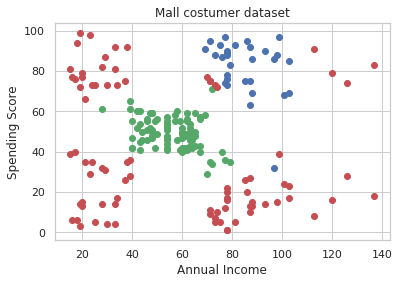

In [13]:
colors = {-1:'r', 0:'g',1:'b',2:'#1f77b4',3:'#1f90b1',4:'#1f50b1',5:'#1f60b1'}
# create a figure and axis
fig, ax = plt.subplots()
# plot each data-point
for i in range(len(df['class'])):
   
  ax.scatter(df['Annual Income (k$)'][i],df['Spending Score (1-100)'][i],color=colors[df["class"][i]])
# if minmax_df['class'][i] == -1:
 #    class1 = class1 + 1
# else:
 #    class0 = class0 + 1 
# set a title and labels
ax.set_title('Mall costumer dataset')
ax.set_xlabel('Annual Income')
ax.set_ylabel('Spending Score')
#print("class 1 : ",class1,"\n")
#print("class 0 : ",class0,"\n")


Next, we try out with other combinations of features

In [14]:
X = np.array(df[["Annual Income (k$)","Gender"]])

for k in range(0,len(sil)):
    
    clustering = OPTICS(min_samples=minpts[k],max_eps=maxeps[k]).fit(X)
    cluster = list(clustering.labels_)   
    if len(np.unique(cluster)) == 1:
         
            continue   
       
    sil[k] = silhouette_score(X,clustering.labels_)


  
maximum = max(sil)
index = sil.index(maximum)
print(index)
print("optimal minpts value :",minpts[index])
print("optimal silhouette coefficient value :",sil[index])


27
optimal minpts value : 37
optimal silhouette coefficient value : 0.42107046296313655


In [15]:
clustering = OPTICS(min_samples=minpts[13],max_eps=maxeps[31]).fit(X)
cluster = list(clustering.labels_)
print(cluster)

values, counts = np.unique(cluster, return_counts=True)
print("cluster number",len(values))

for x in range(0,len(values)):
    if values[x] == -1:
        print("outliers :",counts[x])
    else :
        print("cluster",values[x]," : ",counts[x])
        
df['class'] = cluster

[-1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
cluster number 5
outliers : 61
cluster 0  :  28
cluster 1  :  50
cluster 2  :  36
cluster 3  :  25


This version gives us a couple clusters by ranges of Annual Income (the green cluster whose customers Spending Score is approximately equally distributed from 1 - 100) the two other clusters has their Spending score centered around 50)

Text(0, 0.5, 'Spending Score (1-100)')

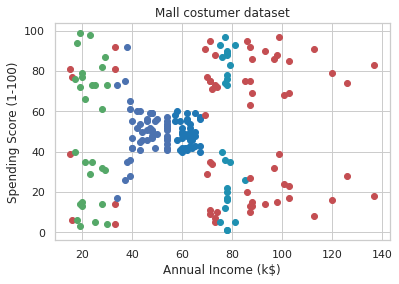

In [16]:
fig,bx = plt.subplots()

for i in range(len(df['class'])):
 bx.scatter(df['Annual Income (k$)'][i], df['Spending Score (1-100)'][i],color=colors[df['class'][i]])


bx.set_title('Mall costumer dataset')
bx.set_xlabel('Annual Income (k$)')
bx.set_ylabel('Spending Score (1-100)')

Next, we try running the algorithm using the two feature Spending Score and age.

In [17]:
X = np.array(df[["Spending Score (1-100)","Age"]])

for k in range(0,len(sil)):

    clustering = OPTICS(min_samples=minpts[k],max_eps=maxeps[k]).fit(X)
    cluster = list(clustering.labels_) 
    if len(np.unique(cluster)) == 1:
        
        continue 
             
    sil[k] = silhouette_score(X,clustering.labels_)
    
maximum = max(sil)
index = sil.index(maximum)
print(index)
print("optimal minpts value :",minpts[index])
print("optimal silhouette coefficient :",sil[index])

17
optimal minpts value : 27
optimal silhouette coefficient : 0.46288486847296384


In [18]:
clustering = OPTICS(min_samples=minpts[17],max_eps=maxeps[17]).fit(X)
cluster = list(clustering.labels_)
print(cluster)

values, counts = np.unique(cluster, return_counts=True)
print("cluster number",len(values))

for x in range(0,len(values)):
    if values[x] == -1:
        print("outliers :",counts[x])
    else :
        print("cluster",values[x]," : ",counts[x])
        
df['class'] = cluster

[-1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, -1, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0, -1, 0]
cluster number 2
outliers : 139
cluster 0  :  61


The cluster 0 is green colored while the red colored points are considered
noise by the algorithm. This clustering recommands to focus on the green cluster. the
annual income of that green population lies within the interval [42,102] which seems to   rather interesting interval. This cluster of individuals contains clients whose spending score    variance is very high as you see the large spread of spending score values of the green cluster. Let’s apply again this procedure to the feature “Age” and “Spending Score”
The silhouette coefficient for this configuration is 0.46. This means that the green cluster   is the most import segment to focus on because it’s dense with young clients with very high Spending Score. The marketing team should prioritize the conservation of this segment (people whose age lies from 20 to 42) 


Text(0, 0.5, 'Spending score')

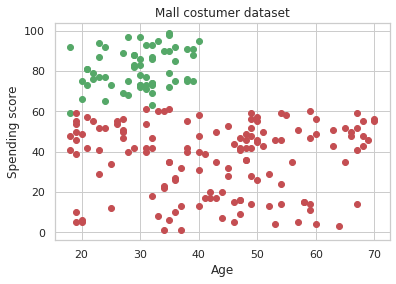

In [19]:
fig,px = plt.subplots()

for i in range(len(df['class'])):
 px.scatter(df['Age'][i], df['Spending Score (1-100)'][i],color=colors[df['class'][i]])


px.set_title('Mall costumer dataset')
px.set_xlabel('Age')
px.set_ylabel('Spending score')